1) 데이터 가져오기

2) 데이터 중강

3) 데이터 전처리

# 0) 모듈 실행

기본 모듈

In [2]:
# Matplotlib 와 pandas 그래프에서 한글 사용 설정
import sys

## 노트북이 코랩에서 실행중인지 체크
if 'google.colab' in sys.modules:
  !echo 'debconf debconf/frontend select Noninterative' | debconf-set-selections
  ## 나눔 폰트 설치
  !sudo apt-get -qq -y install fonts-nanum
  import matplotlib.font_manager as fm
  font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
  for fpath in font_files:
    fm.fontManager.addfont(fpath)

  # 나눔바른고딕 폰트 설정
  import matplotlib.pyplot as plt
  plt.rc('font', family='NanumBarunGothic')
  # 마이너스 기호 표시 오류 수정
  import matplotlib
  matplotlib.rcParams['axes.unicode_minus'] = False


debconf: unable to initialize frontend: Noninterative
debconf: (Can't locate Debconf/FrontEnd/Noninterative.pm in @INC (you may need to install the Debconf::FrontEnd::Noninterative module) (@INC contains: /etc/perl /usr/local/lib/x86_64-linux-gnu/perl/5.34.0 /usr/local/share/perl/5.34.0 /usr/lib/x86_64-linux-gnu/perl5/5.34 /usr/share/perl5 /usr/lib/x86_64-linux-gnu/perl-base /usr/lib/x86_64-linux-gnu/perl/5.34 /usr/share/perl/5.34 /usr/local/lib/site_perl) at (eval 17) line 2, <> line 1.)
debconf: falling back to frontend: Noninteractive
Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KoBERT 설치
- 서비스 작동 중지로 인해 hugging face를 통해 모델 다운로드 전환
- https://complexoftaste.tistory.com/2

In [2]:
# 현재 파이썬 버전 확인
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [3]:
# 파이썬 다운그레이드
!wget https://www.python.org/ftp/python/3.6.9/Python-3.6.9.tgz
!tar xvfz Python-3.6.9.tgz
!Python-3.6.9/configure
!make
!sudo make install
# 변경 후 파이썬 버전
!python --version

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Compiling '/usr/local/lib/python3.6/encodings/cp1026.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1125.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1140.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1250.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1251.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1252.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1253.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1254.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1255.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1256.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1257.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp1258.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp273.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp424.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp437.py'...
Compiling '/usr/local/lib/python3.6/encodings/cp500.py'...
Compilin

In [4]:
# https://github.com/SKTBrain/KoBERT
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-dj7nvm4u/kobert-tokenizer_32d8cbef43d44a18a10662264b4166c1
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-dj7nvm4u/kobert-tokenizer_32d8cbef43d44a18a10662264b4166c1
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [5]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas

# https://github.com/SKTBrain/KoBERT/blob/master/kobert_hf/requirements.txt
!pip install sentencepiece>=0.1.91
!pip install transformers>=4.8.2
!pip install torch>=1.8.1

In [6]:
# 현재 버전 확인
import numpy as np
print(np.__version__)

1.23.4


In [7]:
!pip install numpy==1.23.4

In [8]:
import gluonnlp as nlp

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [9]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [58]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
device = torch.device("cuda:0")

# 1) 데이터 가져오기

## 감성대화 말뭉치
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86
- 일반인 1,500명 대상의 인터뷰 및 크라우드 소싱 수행
- 우울증 환자 대상 WOZ 대화 수집

=> 전처리 과정으로 "한사람만의 대화를 줄글로 변형 - 질문 제거"

### 1. 데이터 가져오기

In [10]:
train = pd.read_excel("/content/drive/MyDrive/0000/Class/졸프/Dataset/AIhub_감성대화/Training_221115_add/원천데이터/감성대화말뭉치(최종데이터)_Training.xlsx")
valid = pd.read_excel("/content/drive/MyDrive/0000/Class/졸프/Dataset/AIhub_감성대화/Validation_221115_add/원천데이터/감성대화말뭉치(최종데이터)_Validation.xlsx")

In [11]:
train_df = train.copy()
valid_df = valid.copy()

### 2. 전처리

In [12]:
# "사람문장3" 결측값 대체
train_df.fillna('',inplace=True)
valid_df.fillna('',inplace=True)

# 문장 병합
train_df['사람문장'] = train_df['사람문장1']+train_df['사람문장2']+train_df['사람문장3']
valid_df['사람문장'] = valid_df['사람문장1']+valid_df['사람문장2']+valid_df['사람문장3']

# "감정 분류"과 "문장"만 추출
train_df = train_df[['사람문장', '감정_대분류']]
valid_df = valid_df[['사람문장', '감정_대분류']]

# 컬럼명 변경
train_df.rename(columns={'사람문장': 'text',
                   '감정_대분류': 'sentiment'}, inplace=True)
valid_df.rename(columns={'사람문장': 'text',
                   '감정_대분류': 'sentiment'}, inplace=True)

# label encoding
le = LabelEncoder()
le=le.fit(train_df['sentiment'])
train_df['target']=le.transform(train_df['sentiment'])

le=le.fit(valid_df['sentiment'])
valid_df['target']=le.transform(valid_df['sentiment'])

# text, target
train_conv = train_df[['text','target']]
valid_conv = valid_df[['text','target']]

<ipython-input-12-77f7edf763db>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns={'사람문장': 'text',
<ipython-input-12-77f7edf763db>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df.rename(columns={'사람문장': 'text',
<ipython-input-12-77f7edf763db>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['target']=le.transform(train_df['sentiment'])

In [13]:
# 라벨 인코딩 결과 확인
sentiment = train_df[['sentiment', 'target']].drop_duplicates(subset=['sentiment']) # sentiment 컬럼에 대해 중복된 값을 갖고 있는 열 제거
df_unique = sentiment.sort_values(by='target', ascending=True)
df_unique = df_unique.reset_index(drop=True)
df_unique

,sentiment,target
0,기쁨,0
1,당황,1
2,분노,2
3,불안,3
4,상처,4
5,슬픔,5


# 2) 데이터 증강
데이터 불균형으로 인해 분류 전에 전처리하는 방식인 smote 택함

**SMOTE(= Synthetic Minority Over-sampling Technique)**

SMOTE는 합성을 기반으로 하는 방법으로, minority class의 샘플을 가져와 이들을 잇는 선에서 중간값을 택하여 만들어내는 방식

Train

In [14]:
# SMOTE : 오버샘플링
from imblearn.over_sampling import RandomOverSampler
text = train_conv.text.to_numpy().reshape(-1, 1)
target = train_conv.target.to_numpy().reshape(-1, 1)

oversample = RandomOverSampler()

X_oversample, y_oversample = oversample.fit_resample(text, target)
train_conv2 = pd.DataFrame({"text": X_oversample.reshape(-1), 'target': y_oversample.reshape(-1)})
train_conv2

,text,target
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.그냥 내가 해결하는 게 나아. 남들한테...,2
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....,2
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,2
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,2
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.상사인 나에게 먼...,2
...,...,...
55915,내가 장애가 있다고 친구에게 말하자 화를 내서 슬퍼.장애가 있다는 걸 듣고 편견을 ...,5
55916,자식들이 자기들 바쁘다고 일 년에 한두 번밖에 오질 않아서 많이 속상하고 슬퍼.나는...,5
55917,오늘 회사에서 큰 실수를 한 것 같아.중요한 발표가 있었는데 많은 사람 앞에서 말을...,5
55918,사람들과의 유대감이 상실된 것 같아서 너무 슬퍼.회사에서 젊은 사람들은 서로 잘 어...,5


<ipython-input-15-1628a5f29409>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_conv.target)
<ipython-input-15-1628a5f29409>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_conv2.target)


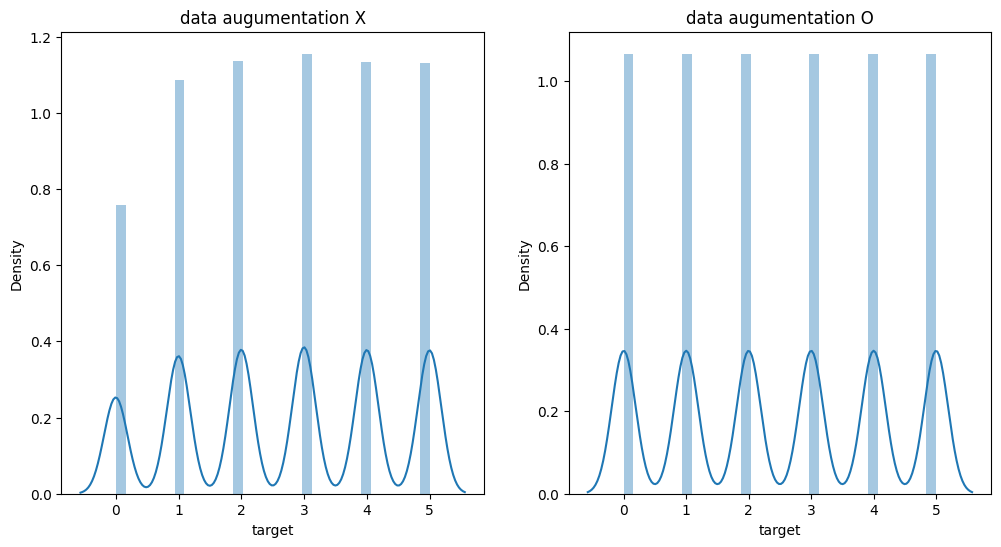

In [15]:
# SMOTE로 클래스별 비율 맞춰준 후 distplot

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 첫 번째 subplot
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
sns.distplot(train_conv.target)
plt.title('data augumentation X')

# 첫 번째 subplot
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
sns.distplot(train_conv2.target)
plt.title('data augumentation O')

# 그래프 표시
#plt.tight_layout()  # subplot 간 간격 조정
plt.show()

In [16]:
train_conv2.groupby(by=["target"]).count()

,text
target,
0,9320
1,9320
2,9320
3,9320
4,9320
5,9320


valid

In [17]:
# SMOTE : 오버샘플링
from imblearn.over_sampling import RandomOverSampler
text = valid_conv.text.to_numpy().reshape(-1, 1)
target = valid_conv.target.to_numpy().reshape(-1, 1)

oversample = RandomOverSampler()

X_oversample, y_oversample = oversample.fit_resample(text, target)
valid_conv2 = pd.DataFrame({"text": X_oversample.reshape(-1), 'target': y_oversample.reshape(-1)})
valid_conv2

,text,target
0,이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너...,3
1,회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워.나에게 너무 크게...,3
2,상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워.무섭게 생겼는데도 업무를 보려면...,3
3,이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다.첫 직장이...,3
4,직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼.내가 낯가림이 심해서 친해질 수 ...,3
...,...,...
7537,아무도 날 좋아해 주지 않는 데 왜 살아야 하는지 모르겠어. 슬퍼.차라리 죽었으면 ...,5
7538,내가 왕따를 당하는데 내 상황을 들어주는 애가 없네.그러니까. 앞으로 어떻게 해야 ...,5
7539,방금 아빠한테 짜증을 냈어. 바로 후회가 되네.성적이 떨어져서 학원에서도 늦게 끝나...,5
7540,친구에게 정말 실망했어.학교폭력을 주도하고 다녔어.,5


<ipython-input-18-9461e10b751b>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_conv.target)
<ipython-input-18-9461e10b751b>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_conv2.target)


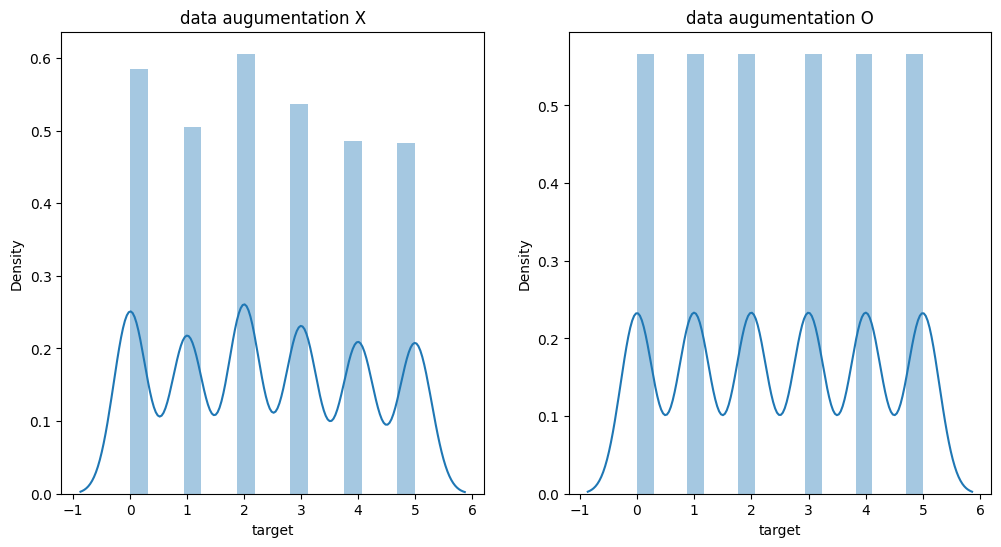

In [18]:
# SMOTE로 클래스별 비율 맞춰준 후 distplot

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 첫 번째 subplot
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
sns.distplot(valid_conv.target)
plt.title('data augumentation X')

# 첫 번째 subplot
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
sns.distplot(valid_conv2.target)
plt.title('data augumentation O')

# 그래프 표시
#plt.tight_layout()  # subplot 간 간격 조정
plt.show()

In [19]:
valid_conv2.groupby(by=["target"]).count()

,text
target,
0,1257
1,1257
2,1257
3,1257
4,1257
5,1257


In [20]:
# 데이터셋이 잘 나눠져있는지 확인
print(len(train_conv2))
print(len(valid_conv2))

55920
7542


# 3) 데이터 전처리
모델 적합을 위해 데이터가 적절히 전처리되어야 하며 이때 전처리는 토큰화, 정수 인코딩, 패딩을 의미함

- https://velog.io/@seolini43/KOBERT%EB%A1%9C-%EB%8B%A4%EC%A4%91-%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EA%B8%B0-%ED%8C%8C%EC%9D%B4%EC%8D%ACColab

In [21]:
dataset_train = train_conv2.copy()
dataset_test = valid_conv2.copy()

In [46]:
# 데이터셋 토큰화
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [59]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

- dataset: 원본 데이터셋
- sent_idx: 문장이 있는 열의 인덱스
- label_idx: 레이블이 있는 열의 인덱스
- bert_tokenizer: KoBERT 모델에 사용할 토크나이저
- max_len: 문장의 최대 길이
- pad: 패딩을 할지 여부를 결정하는 변수
- pair: 문장 페어인지 여부를 결정하는 변수

- 문장을 토큰화하고 특수 토큰([CLS], [SEP])을 추가
- 토큰을 정수 인덱스로 변환하고 패딩을 추가
- 옵션에 따라 문장 페어를 처리(문장 페어가 있는 경우 [SEP] 토큰을 사용하여 두 번째 문장을 추가합니다).

In [63]:
# 하이퍼 파라미터 적용
# Setting parameters - base
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [60]:
# BERTDataset : 각 데이터가 BERT 모델의 입력으로 들어갈 수 있도록 tokenization, int encoding, padding하는 함수
tok = tokenizer.tokenize

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

TypeError: BERTSentenceTransform.__init__() got an unexpected keyword argument 'vocab'

In [ ]:
# torch 형식의 dataset을 만들어 입력 데이터셋의 전처리 마무리
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

# 4) Kobert 모델 구현

In [61]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 7,   # 감정 클래스 수로 조정
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

optimizer와 schedule 설정
- https://velog.io/@sseq007/Kobert-%EB%AA%A8%EB%8D%B8-%EC%82%AC%EC%9A%A91

In [ ]:
# BERT  모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate = 0.5).to(device)

# optimizer와 schedule 설정
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]


optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

# calc_accuracy : 정확도 측정을 위한 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

학습

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

# 5) 테스트

In [ ]:
def predict(predict_sentence): # input = 감정분류하고자 하는 sentence

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False) # 토큰화한 문장
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5) # torch 형식 변환

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval = []
        for i in out: # out = model(token_ids, valid_length, segment_ids)
            logits = i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포가")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 4:
                test_eval.append("중립이")
            elif np.argmax(logits) == 5:
                test_eval.append("행복이")
            elif np.argmax(logits) == 6:
                test_eval.append("혐오가")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [ ]:
# 질문에 0 입력 시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")